# DDF lensed transient coadds access

This repo shows how to access the catalog of lensed transients inserted in the DC2's deep drilling fields and how to create coadd images. So far only the first two year worth of simulation have been processed. If you find that there are more recent processings available that are not being used here, please feel free to submit an issue [here](https://github.com/LSST-strong-lensing/DC2-notebooks/issues).

This notebook is largely based on [DP0 notebook tutorials](https://github.com/rubin-dp0/tutorial-notebooks), initially written by Melissa Graham. 

**Created:** 05-11-2022 by Rémy Joseph
**Last reviewed:** 05-11-2022 by Rémy Joseph


## Introduction

Lensed transients and their host and lensed galaxies were introduced in DC2 run 3.1i as part of the [Lens Sprinkler project](https://portal.lsstdesc.org/DESCPub/app/PB/show_project?pid=35) led by Bryce Klambach and Ji Won Park. Their work should be acknowledged in any published materials that makes use of this work.
The Deep Drilling Fields (DDF) were injected with a sample of a few 1000s lensed quasars and supernovae. This notebook is intended to help anyone who might want to use this sample to run their finding or analysis tools.

This notebook makes use of the gen3 butler developped by the projcet. More information can be found in the [LSST science pipelines documentation](https://pipelines.lsst.io/getting-started/dc2-guide.html). 

In [1]:
# Imports
# Generic python packages
import numpy as np
import pylab as plt
from tqdm.notebook import tqdm
import pandas as pd
import sqlite3
import sqlalchemy 
from astropy.time import Time

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
# Some plotting tools
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
from astropy.visualization import make_lupton_rgb
from lsst.afw.image import MultibandExposure
import lsst.geom as geom
import lsst.afw.coord as afwCoord
import lsst.geom as afwGeom
afwDisplay.setDefaultBackend('matplotlib')

# imports python's garbage collector
import gc                            

import warnings
warnings.simplefilter("ignore", category=UserWarning)

The Butler is the object that enables us to retrieve, read and write data. To create the Butler, we need to provide it with a path to the data set, which is called a "data repository". Butler repositories have both a database component and a file-like storage component; the latter can can be remote (i.e., pointing to an S3 bucket) or local (i.e., pointing to a directory on the local file system), and it contains a configuration file (usually butler.yaml) that points to the right database.

At the moment only tracts 35, 36, 42 and 43 in patch 4848 have 2-years depth coadds. We therefore limit the dataset query to this patch.

In [2]:
repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo'
collections = ['u/jchiang8/coadds_ddf_y1-y2_4848_assembleCoadd']

butler = dafButler.Butler(repo, collections=collections)
skymap = butler.get("skyMap")

#Time of end of year-2
endy2 = Time('2023-12-31T06:55:22.651', format='isot', scale='utc')

dsrefs = list(set(butler.registry.queryDatasets('deepCoadd', tract=4848)))

In [3]:
def is_in_region(ra, 
                 dec, 
                 butler, 
                 time=None, 
                 skymap=None, 
                 regions=[{"tract": [4848], 
                           "patches": [35,36,42,43], 
                           "time": [[Time('2022-01-01T03:21:12.552', 
                                         format='isot', 
                                         scale='utc'),
                                    Time('2023-12-31T06:55:22.651', 
                                         format='isot', 
                                         scale='utc')]]}]):
    """
    Returns True if a set of coordinates (including time) is in a given region.
    
    Parameters
    ----------
    ra, dec: float
        Ra and Dec Coordinates.
    butler: lsst.daf.persistence.Butler
        servant providing access to a data repository
    time: astropy.time
        time of observation (event).
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    regions: array
        Array of dictionnaries containing available patches, tracts and time limits.
        
    Returns
    -------
    is_in: bool
        True if ‘(ra, dec)‘ is in ‘region‘
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    
    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tract = skymap.findTract(radec)
    patch = tract.findPatch(radec)
    
    for r in regions:
        if tract.getId() in r["tract"]:
            if patch.getSequentialIndex() in r["patches"]:
                if time is not None:
                    if np.size(r["time"]) > 0:
                        for span in r["time"]:
                            if (time < span[1]) and (time > span[0]):
                                return True
                else:
                    return True

    return False
    

# Load the lensed transient truth

Here we load the catalogs for inserted lensed transients that were generated as part of the LensSprinkler project. These are the truth tables that give the positions of the simulated lensed transients as they were inserted. 

It is possible to overlay the patches that have been processed so far. Note that it takes a few seconds to build so by default that display is not produced, but if you set ‘show_patches‘ ti ‘True‘, the patches will appear on the plot.

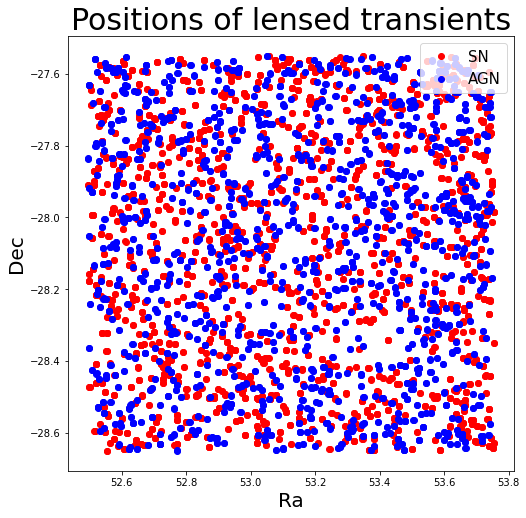

In [4]:
# Databases and location for truth catalogs
folder = '/global/cfs/cdirs/descssim/DC2/Run3.0i/truth_tables/'
truth_sn = 'updated_lensed_sne_truth.db'
truth_agn = 'updated_lensed_agn_truth.db'

# Set to true to visualize the tract:4848, patches:35,36,42,43 area.
show_patches = False

try:
    conn_sn = sqlite3.connect(folder+truth_sn)   
    conn_agn = sqlite3.connect(folder+truth_agn)   
except Exception as e:
    print(e)

#Now in order to read in pandas dataframe we need to know table name
cursor = conn_sn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

sn = pd.read_sql_query('SELECT * FROM lensed_sne', conn_sn)
conn_sn.close()

cursor = conn_agn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

agn = pd.read_sql_query('SELECT * FROM lensed_agn', conn_agn)
conn_agn.close()

fig, ax = plt.subplots()
plt.title('Positions of lensed transients', fontsize = 30)
plt.plot(sn.ra, sn.dec, 'or', label = 'SN')
plt.plot(agn.ra, agn.dec, 'ob', label = 'AGN')
plt.xlabel('Ra', fontsize = 20)
plt.ylabel('Dec', fontsize = 20)
plt.legend(fontsize = 15, loc="upper right")


# Display available patches
if show_patches == True:
    patches = []
    
    for tractInfo in skymap:
        if tractInfo.getId() == 4848:
            for patch in tractInfo:
                if patch.getSequentialIndex() in [35, 36, 42, 43]:
                    ibb=patch.getInnerBBox()
                    tWCS=tractInfo.getWcs()
                    corners = []
                    for corner in ibb.getCorners():
                        p = geom.Point2D(corner.getX(), corner.getY())
                        coord = tWCS.pixelToSky(p)
                        corners.append([coord.getRa().asDegrees(), coord.getDec().asDegrees()])
                    #print(corners)
                    polygon = Polygon(corners,True)
                    patches.append(polygon)
    
    
    p = PatchCollection(patches, cmap=cm.jet, alpha=0.4)
    ax.add_collection(p)  

plt.show()

To view all the information available about each image, in each catalog, uncomment the following line:

In [5]:
#print(sn.columns)
#print(agn.columns)

This catalog contains the positions for each image of a strongly lensed transient. This means that a quadrupely lensed supernova will have 4 entries in the catalog: one for each image. In the next box we produce the approximate coordinates of the lenses by averaging over the image coordinates. 

In [6]:
# SN catalog

def get_lens_radec(cat, butler, region=None, time=False, skymap=None):
    
    if skymap is None:
        skymap = butler.get("skymap")
    inumber = -1
    radec = []
    lens_radec = []
    for index, row in cat.iterrows():
        if row.image_number == inumber+1:
            radec.append([row.ra, row.dec])
        else: 
            #assert len(radec) in [2,4], f"there should be either 2 or 3 images in a lens system but {len(radec)} were found"
            lens_ra, lens_dec = np.mean(radec, axis=0)
            # Only saves the lenses that are in the processed regions
            if time == True:
                t = Time(row.t0+row.t_delay, format='mjd')
            else:
                t = None
            if is_in_region(lens_ra, lens_dec, butler, time=t, skymap=skymap):
                lens_radec.append({'coord': np.mean(radec, axis=0), 'image_pos':radec, 'n_images':inumber+1})
            radec = []
            radec.append([row.ra, row.dec])
            
        inumber = row.image_number
    return lens_radec

agn_lenses = get_lens_radec(agn, butler, skymap=skymap)
sn_lenses = get_lens_radec(sn, butler, skymap=skymap, time=True)

print(f"There are {len(agn_lenses)} lensed AGNs in tract 4848 and {len(sn_lenses)} lensed supernovae exploded during Years 1-2.")

There are 114 lensed AGNs in tract 4848 and 25 lensed supernovae exploded during Years 1-2.


## Making cutouts

We now use the butler and the plotting routines of the stack to make functions that will end up producing patch images of the lensed transients in the catalog.

In [7]:
def createRGB(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb



def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    
    wcs = tractInfo.getWcs()
    xy = geom.PointI(wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    
    parameters = {'bbox': bbox}
    try:
        cutout_image = butler.get(datasetType, parameters=parameters, dataId=coaddId)
        return cutout_image
    except:
        return None
    


def remove_figure(fig):
    """Remove a figure to reduce memory footprint. """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()      # clear the figure
    plt.close(fig) # close the figure
    gc.collect()   # call the garbage collector



# Display colour cutouts

We produce colour images of coadds by pulling each of the desired bands one by one (here `[g, r, i]`). They are then frame into a MultibandExposure object that can be displayed unsing `createRGB`.

In [8]:

def display_lenses(ra, dec, transient_pos, skymap=None):
    """ Display an RGB image of object at position ra, dec.
    """
    
    if skymap == None:
        skymap = butler.get("skymap")
    
    cutout_g = cutout_coadd(butler, 
                            ra, 
                            dec, 
                            band='g',
                            datasetType='deepCoadd', 
                            cutoutSideLength=51, 
                            skymap=skymap)
    
    if cutout_g != None:
        wcs = cutout_g.getWcs()
        bbox = cutout_g.getBBox()
        x, y = [], []
        for pos in transient_pos:
            pos = geom.SpherePoint(pos[0], pos[1], geom.degrees)
        
            xp, yp = wcs.skyToPixel(pos)
            x.append(xp-bbox.getMinX())
            y.append(yp-bbox.getMinY())
            

        cutout_r = cutout_coadd(butler, 
                                ra, 
                                dec, 
                                band='r',
                                datasetType='deepCoadd', 
                                cutoutSideLength=51, 
                                skymap=skymap)
        cutout_i = cutout_coadd(butler, 
                                ra, 
                                dec, 
                                band='i',
                                datasetType='deepCoadd', 
                                cutoutSideLength=51, 
                                skymap=skymap)
        
        # Multiband exposures need a list of images and filters
        coadds = [cutout_g, cutout_r, cutout_i]
        coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)
       
        fig, ax = plt.subplots(figsize=(20, 20), nrows=1, ncols=2)
        
        # original make_lupton_rgb without any scaling
        rgb_original = createRGB(coadds.image, 
                                 bgr=['g', 'r', 'i'], 
                                 scale=None)
        ax[0].imshow(rgb_original, origin='lower')
        ax[0].set_title('original', fontsize=30)
        ax[0].plot(x, y, 'ok')
        
        # make_lupton_rgb with scaled rgb channels
        ax[1].set_title('re-scaled', fontsize=30)
        rgb_scaled = createRGB(coadds.image, 
                               bgr=['g', 'r', 'i'],
                               scale=[0.6, 0.7, 1.0])
        ax[1].imshow(rgb_scaled, origin='lower')
        ax[1].plot(x, y, 'ok', markersize=5)
        
        ax[0].set_axis_off()
        ax[1].set_axis_off()
        plt.show()
        
        # clean up memory
        remove_figure(fig)

    
    pass

We display all the lensed AGNs in original colour and with the Lupton colour mapping ([Lupton et al. 2003](https://arxiv.org/pdf/astro-ph/0312483.pdf)) which applies an Asinh rescaling of the intensities to better preserve colours and contrasts. 

In [ ]:
# Display the 5 first AGNs in the list
for agnl in agn_lenses[:2]:
    display_lenses(agnl['coord'][0], agnl['coord'][1], agnl['image_pos'], skymap=skymap)

In [ ]:
# Display all of the 25 lensed SN that exploded in tract 4848 during Y1-Y2
for snl in sn_lenses[:2]:
    display_object(snl['coord'][0], snl['coord'][1],  [snl['catalog'].ra, snl['catalog'].dec], skymap=skymap)